In [2]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import collections

In [3]:
import copy
import warnings
import numpy as np 
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from numpy.random import choice
from scipy.cluster.hierarchy import linkage
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import ClusterNode

In [214]:
import numpy as np
from typing import List, Tuple, Union, Iterable
from scipy.cluster.hierarchy import to_tree
from scipy.cluster.hierarchy import ClusterNode

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

In [6]:
seed_pool = X_pool[seed_set]
seed_pool_label = y_pool[seed_set]

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import to_tree

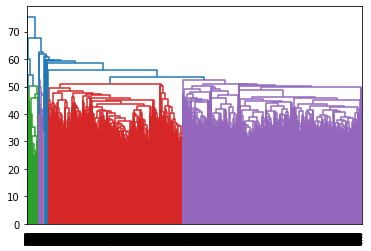

In [24]:
dendrogram(full_tree)
plt.show()

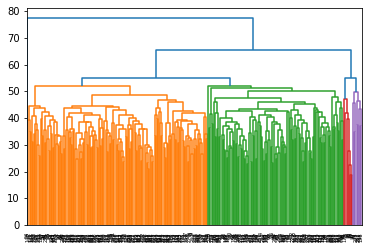

In [52]:
dendrogram(seed_tree)
plt.show()

In [72]:
from typing import List, Tuple, Union, Iterable

In [672]:
class myHS(object):
    def __init__(self, linkage:np.ndarray,y):
        keys = set(y)
        d = {key: 0 for key in keys}
        self.n_class = len(keys)

        self.beta = 2
        self.rootnode,self.nodelist  = to_tree(linkage,rd = True)
        
        self.complete_tree(self.rootnode, self.nodelist)
        self.n_nodes = len(self.nodelist)

        #self.c = np.zeros((self.n_nodes,n_class)) 
        self.label_count = np.array([d for i in range(self.n_nodes)])
        #the count of each class in points sampled from node.

        self.label_count = np.zeros((self.n_nodes,self.n_class))
        self.proba = np.zeros((self.n_nodes,self.n_class))
        #the fraction of each class in points sampled from node.    
        

        self.n = np.zeros(self.n_nodes)
        self.admissible = np.array(np.array([False]*self.n_nodes*self.n_class).reshape(self.n_nodes,self.n_class))

        # Record score for each node
        self.score = np.zeros(len(self.nodelist))

        # Record if achieve score
        self.prune = np.zeros(len(self.nodelist))

        # Record the labels
        self.label = np.zeros(len(self.nodelist))

        self.UB = np.zeros((self.n_nodes,self.n_class))
        self.LB = np.zeros((self.n_nodes,self.n_class))

    def complete_tree(self,rootnode,nodelist):
        rootnode.parent = None
        for node in nodelist:
            if node.get_left():
                node.left.parent = node
            if node.get_right():
                node.right.parent = node
            node.sampled = 0
            # if node.is_leaf():
            #     node.queryed = False
    
   
    def select(self,P):
        
        p_UB = self.UB[P]
        L = self.label[P].astype(int)
        w = np.array([self.nodelist[node].count for node in P])
        p_UB = p_UB[np.arange(len(p_UB)),L]

        count = w *(1-p_UB)

        return random.choices(P,weights = count/sum(count) )[0]


    def select_LB(self,P):
        
        p_LB = self.LB[P]
        L = self.label[P].astype(int)

        w = np.array([self.nodelist[node].count for node in P])

        p_LB = p_LB[np.arange(len(p_LB)),L]

        count = w *(1-p_LB)
        # if np.sum(prob) == 0:
        #     return choice(prunning)
        #return choice(prunning,p = prob)
        #print(random.choices(P,weights = count/sum(count) ))
        return random.choices(P,weights = count/sum(count) )[0]
    
    def leaves(self, node,leaf_list = None):

        node = self.nodelist[node]
        if not leaf_list:
            leaf_list = []
        if node.is_leaf():
            leaf_list.append(node)
            return leaf_list
        else:
            leaf_list = self.leaves(node.left.id,leaf_list)
            leaf_list = self.leaves(node.right.id,leaf_list)
            return leaf_list


    def get_leaves(self, node:Union[ClusterNode,int],leaves:List[ClusterNode] = None)-> List:

        node = self.nodelist[node] if not isinstance(node,ClusterNode) else node
        if not leaves:
            leaves = []
        if node.is_leaf():
            leaves.append(node)
            return leaves
        else:
            leaves = self.get_leaves(node.left,leaves)
            leaves = self.get_leaves(node.right,leaves)
            return leaves

    def rand_pick(self,node,leaf_list=None):
        
        leaves_list = self.leaves(node)
        #print(sorted([node.id for node in leaves_list]))
        z = random.choice(leaves_list)
        return z

    def update_empirical_counts_proba(self,
                          current, 
                          v,
                          label):

        current = self.nodelist[current] if not isinstance(current,ClusterNode) else current
        v = self.nodelist[v] if not isinstance(v,ClusterNode) else v
        # if not current.queryed:
        #     current.queryed = True
        while current and current.id <= v.id:
        #
            self.label_count[current.id][label]+=1
            self.n[current.id] +=1
            current = current.parent
     
        self.n = self.n.reshape((len(self.n), 1))      

        self.proba = self.label_count/self.n 
        
        # self.proba = np.array([list(self.label_count[i].values())/self.n[i] for i in range(self.label_count.shape[0])])
        # self.proba = np.nan_to_num(self.proba,posinf = np.NaN )
        #self.proba = self.label_count[i]/self.n[:,None]
        #np.nan_to_num(x, posinf=0)

    def update_admissible(self):
        delta = 1/self.n + np.sqrt(self.proba*(1-self.proba)/self.n)
        lower = np.fmax(self.proba-delta,0)
        upper = np.fmin(self.proba+delta,1)
        
        for l in np.arange(self.n_class):
            upper_lp = np.delete(upper,l,axis = 1)
            self.admissible[:,l] = np.all((1-lower[:,l][:,None])<self.beta*(1-upper_lp),axis = 1)
        
        self.E_vl = 1-self.proba
        self.E_vl[~self.admissible] = 1
        self.UB = upper
        self.LB = lower
    
    def update_score(self):
        for i in range(len(self.nodelist)):
            current_node = self.nodelist[i]
            if current_node.is_leaf():
                self.score[i] = np.nanmin(self.E_vl[i])
                self.prune[i] = False
            else:
                if self.admissible[i,:].any():
                    
                    a_score = (current_node.left.count/current_node.count) * self.score[current_node.left.id]
                    b_score = (current_node.right.count/current_node.count) * self.score[current_node.right.id]

                    if a_score+b_score < np.nanmin(self.E_vl[i]):
                        self.score[i] = a_score+b_score
                        self.prune[i] = True
                    else:
                        self.score[i] = np.nanmin(self.E_vl[i])
                        self.prune[i] = False
                else:
                    self.score[i] = np.nanmin(self.E_vl[i])
                    self.prune[i] = False

    def recursively_update_label(self,node,P):

        
        if not isinstance(node, ClusterNode):
            node = self.nodelist[node]
        if not isinstance(P, ClusterNode):
            P = self.nodelist[P]

        if node.is_leaf():
            self.label[node.id] = self.label[P.id]
        else:
            self.recursively_update_label(node.left,P)
            self.recursively_update_label(node.right,P)

    def update_L_P(self,P):
        P_prime = []
        for i in P:
            node = self.nodelist[i]
            if self.prune[i]:

                label = np.where(self.admissible[i,:])[0][0]
                P_prime.append(node.left.id)
                P_prime.append(node.right.id)

                self.label[node.left.id] = label
                self.label[node.right.id] = label
            else:
                P_prime.append(i)
                self.label[node.id] = np.nanargmin(self.E_vl[i])
                
        for p in P_prime:
            self.recursively_update_label(p,p)
        return P_prime




In [10]:
mylinkage = hierarchy.linkage(seed_pool,method='average')


In [546]:
#mylist = [i for i in range(300)]
mylist = [76,55,247,282,212,23,37,190,68,41]

In [680]:
def Cluster_adaptive_active_learning(X,y,batch_size,max_size,mylinkage):
    P_list = []
    #X_linkage = linkage(X,method='average')
    Tree = myHS(mylinkage,y)
    P = np.array([Tree.rootnode.id])
    for i in range(30):
        
        for i in range(60):
            v = Tree.select_LB(P)
            z = Tree.rand_pick(v)
            label = y[z.id]            
            Tree.update_empirical_counts_proba(z,v,label)
            #Tree.update_empirical(z,v,label)
        Tree.update_admissible()
        Tree.update_score()
        P = Tree.update_L_P(P)
        
        # Tree.update_admissible2()
        #P = Tree.best_pruning_and_labeling(P)
        # print(P)
        P_list.append(P)
    return P_list


In [683]:
P_list = Cluster_adaptive_active_learning(seed_pool,new_label,10,3000,mylinkage)

In [684]:
[len(i)for i in P_list]

[2,
 3,
 4,
 6,
 9,
 13,
 19,
 24,
 34,
 48,
 62,
 77,
 92,
 106,
 119,
 137,
 160,
 174,
 181,
 191,
 200,
 215,
 224,
 231,
 235,
 242,
 249,
 251,
 255,
 256]

In [535]:
labelset = list(set(seed_pool_label))

In [64]:
new_label = []
for item in copyed:
    for i in range(len(labelset)):
        if item == labelset[i]:
            new_label.append(i)

In [16]:
Tree_full = HierarchicalSampling(mylinkage,300,30)

In [633]:
def Cluster_adaptive_active_learning_2(X,y,batch_size,max_size,mylinkage):
    #X_linkage = linkage(X,method='average')
    #sampling_method = "active"
    Tree = HierarchicalSampling(mylinkage,300,30)
    P = np.array([Tree.btree.id])
    # L = 
    for i in range(50):
        for i in range(60):
            v = Tree.active_sampling(P)
            leaves = Tree.get_leaves(v)
   

            #print(sorted([node.id for node in leaves]))
            leaf = np.random.choice(leaves)
            #print(leaf.id)
            #leaf = Tree.node_list[mylist[i]]
            label = y[leaf.id]
            Tree.update_empirical(leaf,v,label)

        Tree.update_admissible()
        P = Tree.best_pruning_and_labeling(P)
        print("P: ",P)
        for p in P:
            Tree.assign_labels(p, p)
        

In [634]:
Cluster_adaptive_active_learning_2(seed_pool,new_label,10,3000,mylinkage)

P:  [54, 597]
P:  [54, 595, 596]
P:  [54, 593, 594, 596]
P:  [54, 576, 589, 44, 592, 596]
P:  [44, 54, 530, 572, 577, 585, 552, 591, 596]
P:  [44, 54, 148, 462, 552, 544, 558, 570, 575, 574, 580, 587, 588, 596]
P:  [44, 54, 148, 462, 396, 508, 552, 558, 440, 556, 548, 559, 526, 567, 512, 563, 582, 583, 236, 581, 596]
P:  [44, 54, 148, 236, 396, 440, 462, 508, 392, 437, 100, 473, 548, 552, 540, 546, 534, 545, 559, 450, 553, 514, 550, 549, 573, 582, 568, 578, 596]
P:  [44, 54, 100, 148, 236, 392, 396, 437, 440, 450, 462, 473, 508, 514, 534, 476, 483, 474, 531, 520, 535, 548, 549, 502, 537, 552, 527, 539, 559, 562, 564, 573, 566, 571, 582, 596]
P:  [44, 54, 100, 148, 236, 392, 396, 437, 440, 450, 22, 171, 473, 474, 476, 460, 465, 288, 482, 449, 471, 514, 457, 516, 519, 525, 531, 534, 535, 503, 523, 107, 453, 548, 549, 552, 559, 538, 542, 551, 560, 536, 547, 426, 565, 573, 94, 555, 596]
P:  [22, 44, 54, 94, 100, 107, 148, 171, 236, 288, 392, 396, 426, 437, 440, 449, 450, 453, 457, 93, 422,

In [529]:
class HierarchicalSampling(object):
    def __init__(self,linkage:np.ndarray, n_samples:int, n_class:int):
        self.n_samples = n_samples
        self.n_class = n_class
        self.btree, self.node_list = self._construct_btree(linkage)
        self.lc = np.array([x.count for x in self.node_list],dtype = np.int)
        self.n_nodes = len(self.node_list)
        self.major_label = np.zeros(self.n_nodes,dtype = np.int)
        self.c = np.zeros((self.n_nodes,n_class)) 
        #the count of each class in points sampled from node.
        self.p = np.zeros((self.n_nodes,n_class))
        #the fraction of each class in points sampled from node.
        self.sampled = np.zeros(self.n_nodes)
        #the number of points sampled in the subtree rooted at each node.
        self.A = np.zeros((self.n_nodes,n_class),dtype = bool)
        #the admmisible score of node i and label l.
        self.p_LB = np.zeros((self.n_nodes,n_class))
        self.p_UB = np.zeros((self.n_nodes,n_class))
        #the lower bound of the probability for node i and label l.
    def _construct_btree(self,linkage):
        btree, node_list = to_tree(linkage,rd = True)
        btree.parent = None
        for node in node_list:
            if node.left:
                node.left.parent = node 
            if node.right:
                node.right.parent = node
            node.sampled = 0
            if node.is_leaf():
                node.queryed = False
        return btree, node_list
    
    @property
    def leaves_count(self):
        return self.lc

    def get_leaves(self, node:Union[ClusterNode,int],leaves:List[ClusterNode] = None)-> List:
        """
        Get the list of leaves node under the subtree.

        Parameters
        ----------
        node : Union[ClusterNode,int]
            The root node of the subtree.

        Returns
        -------
        List
            A list contain the leaves nodes.

        """
        node = self.node_list[node] if not isinstance(node,ClusterNode) else node
        if not leaves:
            leaves = []
        if node.is_leaf():
            leaves.append(node)
            return leaves
        else:
            leaves = self.get_leaves(node.left,leaves)
            leaves = self.get_leaves(node.right,leaves)
            return leaves
            
    def update_empirical(self,
                          current:Union[ClusterNode,int], 
                          subroot:Union[ClusterNode,int],
                          label:int):

        current = self.node_list[current] if not isinstance(current,ClusterNode) else current
        subroot = self.node_list[subroot] if not isinstance(subroot,ClusterNode) else subroot
        if not current.queryed:
            current.queryed = True
        while current and current.id <= subroot.id:
            self.c[current.id][label]+=1
            self.sampled[current.id] +=1
            current = current.parent
        self.p = self.c/self.sampled[:,None]
    
    
    def update_admissible(self,beta:float = 2.0):

        delta = 1/self.sampled[:,None]+np.sqrt(self.p*(1-self.p)/self.sampled[:,None])
        p_LB = np.fmax(self.p-delta,0)
        p_UB = np.fmin(self.p+delta,1)
        for l in np.arange(self.n_class):
            po_UB = np.delete(p_UB,l,axis = 1)
            self.A[:,l] = np.all(p_LB[:,l][:,None]>beta*po_UB-beta+1,axis = 1)
            # self.A[:,l] = p_LB[:,l]>1/3 #For 2 classes case.
        e_tilde = 1-self.p
        e_tilde[~self.A] = 1
        self.e_tilde = e_tilde
        self.p_LB = p_LB
        self.p_UB = p_UB
    
    def best_pruning_and_labeling(self,
                                  prunning:Iterable[Union[ClusterNode,int]],
                                  beta:float = 2.0
                                  )-> Tuple[np.ndarray,int]:
    
        e_tilde = self.e_tilde
        prunning = [x.id if isinstance(x,ClusterNode) else x for x in prunning]
        score = np.zeros(len(self.node_list))
        new_prunnings = []
        for idx, node in enumerate(self.node_list):
            if node.is_leaf():
                score[idx] = np.nanmin(e_tilde[idx])
            else:
                score_curr = np.nanmin(e_tilde[idx])
                if np.any(self.A[idx,:]):
                    left = node.left
                    right = node.right
                    score_desc = left.count/node.count * score[left.id]+\
                                 right.count/node.count * score[right.id]
                    score[idx] = np.minimum(score_desc,score_curr)
                else:
                    score_desc = np.inf
                    score[idx] = score_curr
            if idx in prunning:
                if node.is_leaf():
                    label = np.nanargmin(e_tilde[idx])
                    prunning_ = [idx]
                else:
                    label = np.nanargmin(e_tilde[idx]) if score_curr<score_desc else np.where(self.A[idx,:])[0][0]
                    prunning_ = [idx] if score_curr<score_desc else [node.left.id,node.right.id]
                for p in prunning_:
                    self.major_label[p] = label
                new_prunnings.extend(prunning_)
        return new_prunnings
    
    def assign_labels(self, 
                       current:Union[ClusterNode,int], 
                       subroot:Union[ClusterNode,int]):

        subroot = self.node_list[subroot] if not isinstance(subroot, ClusterNode) else subroot
        current = self.node_list[current] if not isinstance(current, ClusterNode) else current
        if current.is_leaf():
            self.major_label[current.id] = self.major_label[subroot.id]
        else:
            self.assign_labels(current.left,subroot)
            self.assign_labels(current.right,subroot)
            
    def active_sampling(self,prunning:List[int])->int:
 
        p_LB = self.p_LB[prunning]
        w = self.leaves_count[prunning]
        L = self.major_label[prunning]
        p_LB = p_LB[np.arange(len(p_LB)),L]
        prob = w*(1-p_LB)
        if np.sum(prob) == 0:
            return random.choice(prunning)
        prob = prob/prob.sum()
        #return choice(prunning,p = prob)
        return random.choices(prunning, weights = prob)[0]

In [694]:
data = np.array([[3],[1],[2],[4],[3.5],[2.4],[1.8],[7],[8],[9],[9],[7.5],[8.4],[9.8]])
data_linkage = hierarchy.linkage(data,method='average')

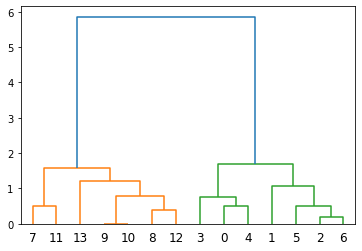

In [695]:
dendrogram(data_linkage, show_contracted=True)
plt.show()

In [701]:
data_linkage

array([[ 9.        , 10.        ,  0.        ,  2.        ],
       [ 2.        ,  6.        ,  0.2       ,  2.        ],
       [ 8.        , 12.        ,  0.4       ,  2.        ],
       [ 5.        , 15.        ,  0.5       ,  3.        ],
       [ 0.        ,  4.        ,  0.5       ,  2.        ],
       [ 7.        , 11.        ,  0.5       ,  2.        ],
       [ 3.        , 18.        ,  0.75      ,  3.        ],
       [14.        , 16.        ,  0.8       ,  4.        ],
       [ 1.        , 17.        ,  1.06666667,  4.        ],
       [13.        , 21.        ,  1.2       ,  5.        ],
       [19.        , 23.        ,  1.59      ,  7.        ],
       [20.        , 22.        ,  1.7       ,  7.        ],
       [24.        , 25.        ,  5.85714286, 14.        ]])

In [702]:
data_y = np.array([0,0,1,0,0,0,0,1,1,1,1,0,1,1])

In [703]:
Cluster_adaptive_active_learning(data,data_y,10,2,data_linkage)

[[24, 25],
 [19, 23, 20, 22],
 [7, 11, 23, 20, 1, 17],
 [7, 11, 23, 20, 1, 5, 15],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6],
 [7, 11, 23, 20, 1, 5, 2, 6]]